# Рекомендация тарифов

# Содержание:

[1 Откройте и изучите файл](#Откройте-и-изучите-файл)

[2 Разбейте данные на выборки](#Разбейте-данные-на-выборки)

[3 Исследуйте модели](#Исследуйте-модели)

[4 Проверьте модель на тестовой выборке](#Проверьте-модель-на-тестовой-выборке)

[5 Проверьте модели на адекватность](#(бонус)-Проверьте-модели-на-адекватность)

[Выводы](#Выводы)

## Откройте и изучите файл

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score
from sklearn.dummy import DummyClassifier

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')

In [3]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [5]:
df[['calls', 'minutes', 'messages', 'mb_used', 'is_ultra']].corr()

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


У признаков 'calls' и 'minutes' наблюдается сильная взаимосвязь.

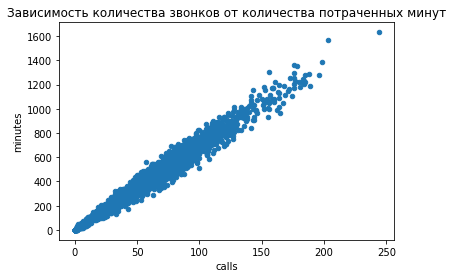

In [6]:
df.plot.scatter(x='calls', y='minutes', title='Зависимость количества звонков от количества потраченных минут')

Сильно коррелированные друг с другом переменные дают модели одну и ту же информацию. В таком случае в модели нужна только одна из этих переменных. Если использовать обе, то модель окажется переобучена и предвзята относительно одного отдельного признака. Поэтому необходимо исключить признак 'calls', так как минуты более полный и информативный признак, на мой взгляд.

In [7]:
df = df.drop(['calls'], axis=1)

In [8]:
df.head()

,minutes,messages,mb_used,is_ultra
0,311.90,83.0,19915.42,0
1,516.75,56.0,22696.96,0
2,467.66,86.0,21060.45,0
3,745.53,81.0,8437.39,1
4,418.74,1.0,14502.75,0


Данные готовы для исследования

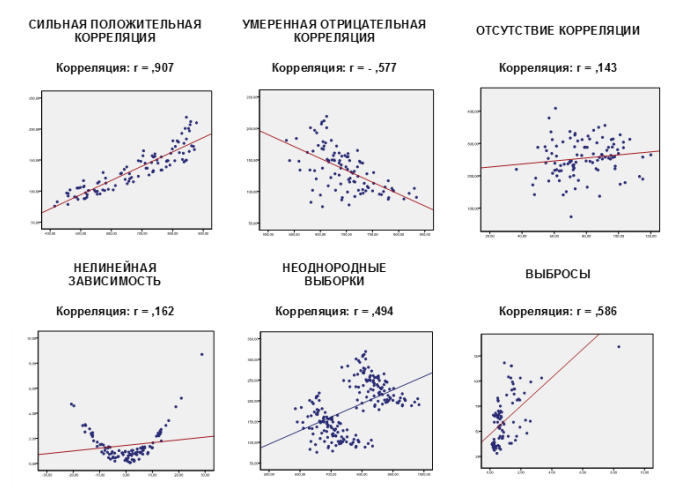

## Разбейте данные на выборки

Способом train_test_split() можно получить только 2 набора данных, поэтому делим датасет в два приема в пропорции 3:1:1.

In [9]:
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']

In [10]:
features_train, features_valid, target_train, target_valid = train_test_split(features, target, 
                                                                              test_size=0.2, random_state=12345)

In [11]:
features_train, features_test, target_train, target_test = train_test_split(features_train, target_train, 
                                                                            test_size=0.25, random_state=12345)

In [12]:
print(features_train.shape, features_valid.shape, features_test.shape) #проверяем правильность разделения

(1928, 3) (643, 3) (643, 3)


In [13]:
print(target_train.shape, target_valid.shape, target_test.shape)

(1928,) (643,) (643,)


Данные разделены: 60% для обучаюшей выборки, по 20% тестовой и валидационной.


## Исследуйте модели

### Дерево решений

In [14]:
model_tree = DecisionTreeClassifier(random_state=12345)
model_tree.fit(features_train, target_train)
predictions_valid = model_tree.predict(features_valid)
result_tree = accuracy_score(target_valid, predictions_valid)
print(result_tree)

0.7262830482115086


Дерево решений показывает неплохую точность предсказаний.

### Дерево решений с изменением гиперпараметра

In [15]:
best_result_tree = 0
best_model_tree = None
max_depth = 0
for depth in range(1,7):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predictions_tree = model.predict(features_valid)
    result_tree= accuracy_score(target_valid, predictions_tree)
    if result_tree > best_result_tree:
        best_result_tree = result_tree
        best_model_tree = model
        max_depth = depth
print(best_result_tree, max_depth)

0.7916018662519441 5


Перебираю гиперпараметр max_depth от 1 до 6. Точность еще выросла!

### Случайный лес

In [16]:
best_model_forest = None
best_result_forest = 0

for est in range(1, 15):
    for depth in range(1, 11):
        model_forest = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model_forest.fit(features_train, target_train)
        predictions_forest = model_forest.predict(features_valid)
        result = model_forest.score(features_valid, target_valid)
        if result > best_result_forest:
            best_result_forest = result
            best_model_forest = model_forest           
print(best_result_forest, best_model_forest)

0.80248833592535 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)


Случайный лес с перебором количества деревьев дает лучший результат.

### Логиcтическая регрессия


In [17]:
model_logistic = LogisticRegression(random_state=12345, solver='lbfgs')
model_logistic.fit(features_train, target_train)
predictions_logistic = model_logistic.predict(features_valid)
result_logistic = model_logistic.score(features_valid, target_valid)
print(result_logistic)


0.7589424572317263


Модель логистической регрессии показывает приемлемую точность.

## Проверьте модель на тестовой выборке

In [18]:
print(best_model_forest.score(features_test, target_test)) #модель случайного леса с изменением гиперпараметра

0.7869362363919129


Лучший результат за моделью случайного леса.

In [19]:
print(best_model_tree.score(features_test, target_test)) # модель дерева с изменением гиперпараметра

0.7667185069984448


In [20]:
print(model_logistic.score(features_test, target_test)) # модель логистической регрессии

0.7262830482115086


In [21]:
features_new = pd.concat([features_train, features_valid]) #объединяю обучающую и валидационную выборки

In [22]:
target_new = pd.concat([target_train, target_valid]) #объединяю данные с целевыми признаками

In [23]:
print(features_new.shape, target_new.shape) #проверка

(2571, 3) (2571,)


In [24]:
model_new = DecisionTreeClassifier(random_state=12345, max_depth=5) #модель дерева решений с изменение глубины
model_new.fit(features_new, target_new)
result1 = model_new.score(features_new, target_new)
print(result1)

0.82341501361338


In [25]:
model_new = RandomForestClassifier(random_state=12345, max_depth=7, n_estimators=5) #модель случайного леса с 
                                                                                    #изменением параметров
model_new.fit(features_new, target_new)
result2 = model_new.score(features_new, target_new)
print(result2)

0.838584208479191


In [26]:
model_new = LogisticRegression(random_state=12345, solver='lbfgs') #модель логистической регресси
model_new.fit(features_new, target_new)
result3 = model_new.score(features_new, target_new)
print(result3)

0.7036172695449242


При увеличении обучающей выборки за счет валидационной, проверка на тестовой выборке показала лучшие результаты для моделей дерева решений и случайного леса, увеличив точность с 0.766 до 0,823 и с 0.787 до 0,839 соответственно.
А для модели логистической регрессии точность упала с 0,726 до 0,704.

## (бонус) Проверьте модели на адекватность

### Модель случайного леса с изменением гиперпараметра

In [27]:
print(precision_score(predictions_forest, target_valid))

0.46938775510204084


In [28]:
print(recall_score(predictions_forest, target_valid))

0.7022900763358778


* precision_score -  это доля объектов действительно принадлежащих данному классу, достаточно низкая. 
* recall_score - доля объектов, действительно относящихся к положительному классу.

### Модель дерева с изменением гиперпараметра

In [29]:
print(precision_score(predictions_tree, target_valid))

0.4030612244897959


In [30]:
print(recall_score(predictions_tree, target_valid))

0.7596153846153846


Эта модель показывает еще меньшее качество

### модель логистической регрессии

In [31]:
print(precision_score(predictions_logistic, target_valid))

0.23979591836734693


In [32]:
print(recall_score(predictions_logistic, target_valid))

0.8867924528301887


Качество этой модели совсем неудовлетворительно.

[Наверх](#Содержание:)

In [33]:
strategies = ['most_frequent']

dummy_results = []
for strategy in strategies:
    dc = DummyClassifier(strategy = strategy, random_state = 42)
    dc.fit(features_new, target_new)
    result = dc.score(features_test, target_test) 
    dummy_results.append({strategy: result}) 
pd.DataFrame(dummy_results)


,most_frequent
0,0.688958


# Выводы

* Данные изучены,
* удалены сильно коррелированные друг с другом признаки с целью предотвратить переобучение модели и предвзятости относительно одного отдельного признака.
* Данные разделены на выборки: 60% для обучаюшей выборки, по 20% тестовой и валидационной.
* построены разные модели
* изучено влияние изменений гиперпараметров некоторых моделей. Влияние максимальной глубины на дерево решений увеличило accuracy c 0.73 до 0.788. А перебор количества деревьев и их глубины модели случайного леса позволил достичь accuracy 0,80.
* модели проверены на тестовой выборке: лучший показатель accuracy принадлежить модели случайного леса с изменение гиперпараметра - 0.777.
* проверены модели на адекватность: наиболее адекватна модель случайного леса с изменением количества деревьев. 
* При увеличении обучающей выборки за счет валидационной, проверка на тестовой выборке показала лучшие результаты для моделей дерева решений и случайного леса, увеличив точность с 0.766 до 0,823 и с 0.787 до 0,839 соответственно. А для модели логистической регрессии точность упала с 0,726 до 0,704.
* все модели достаточно эффективные по сравнению с моделью фиктивного классификатора DummyClassifier.